<a href="https://colab.research.google.com/github/Percy-O/Stroke-Prediction-using-RBF/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow
from keras.optimizers import RMSprop
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from drive.MyDrive.stroke.rbf_keras import kmeans_initializer,rbflayer

%matplotlib inline


# Loading Dataset

In [ ]:
data = pd.read_csv('drive/MyDrive/stroke/stroke_prediction_dataset.csv')
data.head()

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


## Data Shape

In [ ]:
data.shape

(15000, 22)

# Data Information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient ID                15000 non-null  int64  
 1   Patient Name              15000 non-null  object 
 2   Age                       15000 non-null  int64  
 3   Gender                    15000 non-null  object 
 4   Hypertension              15000 non-null  int64  
 5   Heart Disease             15000 non-null  int64  
 6   Marital Status            15000 non-null  object 
 7   Work Type                 15000 non-null  object 
 8   Residence Type            15000 non-null  object 
 9   Average Glucose Level     15000 non-null  float64
 10  Body Mass Index (BMI)     15000 non-null  float64
 11  Smoking Status            15000 non-null  object 
 12  Alcohol Intake            15000 non-null  object 
 13  Physical Activity         15000 non-null  object 
 14  Stroke

## Data Cleaning

In [ ]:
## Checking for null fields

data.isnull().sum()

Patient ID                     0
Patient Name                   0
Age                            0
Gender                         0
Hypertension                   0
Heart Disease                  0
Marital Status                 0
Work Type                      0
Residence Type                 0
Average Glucose Level          0
Body Mass Index (BMI)          0
Smoking Status                 0
Alcohol Intake                 0
Physical Activity              0
Stroke History                 0
Family History of Stroke       0
Dietary Habits                 0
Stress Levels                  0
Blood Pressure Levels          0
Cholesterol Levels             0
Symptoms                    2500
Diagnosis                      0
dtype: int64

In [ ]:
## fill null field with random numbers
data['Symptoms']=data['Symptoms'].fillna('none')
data.head()

,Patient ID,Patient Name,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,...,Alcohol Intake,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Blood Pressure Levels,Cholesterol Levels,Symptoms,Diagnosis
0,18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,...,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
1,62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,...,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
2,32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,...,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
3,6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,...,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Head...",No Stroke
4,48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,...,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


In [ ]:
data.shape

(15000, 22)

In [ ]:
data.isnull().sum()

Patient ID                  0
Patient Name                0
Age                         0
Gender                      0
Hypertension                0
Heart Disease               0
Marital Status              0
Work Type                   0
Residence Type              0
Average Glucose Level       0
Body Mass Index (BMI)       0
Smoking Status              0
Alcohol Intake              0
Physical Activity           0
Stroke History              0
Family History of Stroke    0
Dietary Habits              0
Stress Levels               0
Blood Pressure Levels       0
Cholesterol Levels          0
Symptoms                    0
Diagnosis                   0
dtype: int64

### Split blood pressure levels into
* Systolic
* Disatolic

In [ ]:
data['Systolic']=data['Blood Pressure Levels'].str.split('/').str.get(0)
data['Diastolic']=data['Blood Pressure Levels'].str.split('/').str.get(1)

In [ ]:
data['Systolic']= pd.to_numeric(data['Systolic'],downcast='integer')
data['Diastolic']= pd.to_numeric(data['Diastolic'],downcast='integer')

### Split Cholesterol levels into
* HDL
* LDL

In [ ]:
data['HDL'] = data['Cholesterol Levels'].str.split(',').str.get(0).str.split(':').str.get(1)
data['LDL'] = data['Cholesterol Levels'].str.split(',').str.get(1).str.split(':').str.get(1)

In [ ]:
data['HDL']= pd.to_numeric(data['HDL'],downcast='integer')
data['LDL']= pd.to_numeric(data['LDL'],downcast='integer')

## Dropping unused columns

In [ ]:
data = data.drop(columns=['Patient ID','Symptoms','Cholesterol Levels','Blood Pressure Levels','Patient Name'])

## Groupping Systolic and Diastolic Blood Pressure into ordinal data
* Check the unique values for proper frequency distribution
* Group the data based on some consideration

In [ ]:
Systolic=data['Systolic'].unique()
Systolic

array([140, 146, 154, 174, 121, 132, 178, 179, 141, 119,  91, 127, 114,
        97, 170, 151, 175, 103, 120,  98, 134, 163, 102, 123, 109, 101,
       108, 161,  90, 137, 148, 152, 167, 180, 144, 139, 113, 165, 176,
       166, 128, 116, 122,  96, 126, 100, 130, 111, 117,  92, 149, 142,
       145, 124, 105, 164, 159, 110, 150, 115, 177, 104, 133, 106,  95,
       125,  94,  93, 155, 160, 135, 129, 162, 131, 118, 157, 171, 147,
       112, 172, 169, 153, 158, 168, 136, 173,  99, 143, 107, 138, 156],
      dtype=int16)

### Groupping the values by the range

In [ ]:

systolic_ranges = {
    'Normal': (0, 120),
    'Elevated': (120, 129),
    'Hypertension': (130, 139),
    'Hypertensive Crisis': (140, float('inf'))
}


## Function to categorize the data['Systolic Blood Pressure Levels'] by the S_Group_level


In [ ]:
def categorize_systolic(value):
    for category, (min_value, max_value) in systolic_ranges.items():
        if min_value <= value <= max_value:
            return category
    return None

data['Systolic'] = data['Systolic'].apply(categorize_systolic)
data.head()

,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,Body Mass Index (BMI),Smoking Status,...,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Diagnosis,Systolic,Diastolic,HDL,LDL
0,56,Male,0,1,Married,Self-employed,Rural,130.91,22.37,Non-smoker,...,Moderate,0,Yes,Vegan,3.48,Stroke,Hypertensive Crisis,108,68,133
1,80,Male,0,0,Single,Self-employed,Urban,183.73,32.57,Non-smoker,...,Low,0,No,Paleo,1.73,Stroke,Hypertensive Crisis,91,63,70
2,26,Male,1,1,Married,Never Worked,Rural,189.00,20.32,Formerly Smoked,...,High,0,Yes,Paleo,7.31,Stroke,Hypertensive Crisis,97,59,95
3,73,Male,0,0,Married,Never Worked,Urban,185.29,27.50,Non-smoker,...,Moderate,0,No,Paleo,5.35,No Stroke,Hypertensive Crisis,81,70,137
4,51,Male,1,1,Divorced,Self-employed,Urban,177.34,29.06,Currently Smokes,...,Low,0,Yes,Pescatarian,6.84,Stroke,Elevated,95,65,68


In [ ]:
Diastolic=data['Diastolic'].unique()
Diastolic

array([108,  91,  97,  81,  95,  64, 105,  72, 106,  88,  80, 110,  67,
       102,  84,  86,  60,  70,  94,  74,  65,  85,  63, 104,  69, 103,
       109,  78,  79,  73,  75,  76,  77,  83, 101,  99,  71,  96,  82,
        68,  90,  66, 107,  98,  62, 100,  93,  89,  87,  92,  61],
      dtype=int8)

In [ ]:

diastolic_ranges = {
    'Normal': (0, 60),
    'Elevated': (61, 80),
    'Hypertension': (81, 110),
    'Hypertensive Crisis': (111, float('inf'))
}


In [ ]:
def categorize_systolic(value):
    for category, (min_value, max_value) in diastolic_ranges.items():
        if min_value <= value <= max_value:
            return category
    return None

data['Diastolic'] = data['Diastolic'].apply(categorize_systolic)
data.head()

,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,Body Mass Index (BMI),Smoking Status,...,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Diagnosis,Systolic,Diastolic,HDL,LDL
0,56,Male,0,1,Married,Self-employed,Rural,130.91,22.37,Non-smoker,...,Moderate,0,Yes,Vegan,3.48,Stroke,Hypertensive Crisis,Hypertension,68,133
1,80,Male,0,0,Single,Self-employed,Urban,183.73,32.57,Non-smoker,...,Low,0,No,Paleo,1.73,Stroke,Hypertensive Crisis,Hypertension,63,70
2,26,Male,1,1,Married,Never Worked,Rural,189.00,20.32,Formerly Smoked,...,High,0,Yes,Paleo,7.31,Stroke,Hypertensive Crisis,Hypertension,59,95
3,73,Male,0,0,Married,Never Worked,Urban,185.29,27.50,Non-smoker,...,Moderate,0,No,Paleo,5.35,No Stroke,Hypertensive Crisis,Hypertension,70,137
4,51,Male,1,1,Divorced,Self-employed,Urban,177.34,29.06,Currently Smokes,...,Low,0,Yes,Pescatarian,6.84,Stroke,Elevated,Hypertension,65,68


# Data Statistics Description

In [ ]:
data.describe()

,Age,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Stress Levels,HDL,LDL
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,54.035667,0.249000,0.502933,129.445209,27.474302,0.500267,5.022694,55.064933,125.054267
std,21.063111,0.432448,0.500008,40.487792,7.230201,0.500017,2.873223,14.845410,37.593233
min,18.000000,0.000000,0.000000,60.000000,15.010000,0.000000,0.000000,30.000000,60.000000
25%,36.000000,0.000000,0.000000,94.517500,21.160000,0.000000,2.540000,42.000000,92.000000
50%,54.000000,0.000000,1.000000,128.900000,27.420000,1.000000,5.050000,55.000000,125.000000
75%,72.000000,0.000000,1.000000,164.592500,33.720000,1.000000,7.520000,68.000000,158.000000
max,90.000000,1.000000,1.000000,200.000000,40.000000,1.000000,10.000000,80.000000,190.000000


# Exploratory Data Analysis

### Stroke Data Distribution by categories

In [ ]:
data['Stroke History'].unique()

array([0, 1])

Diagnosis
No Stroke    7532
Stroke       7468
Name: count, dtype: int64


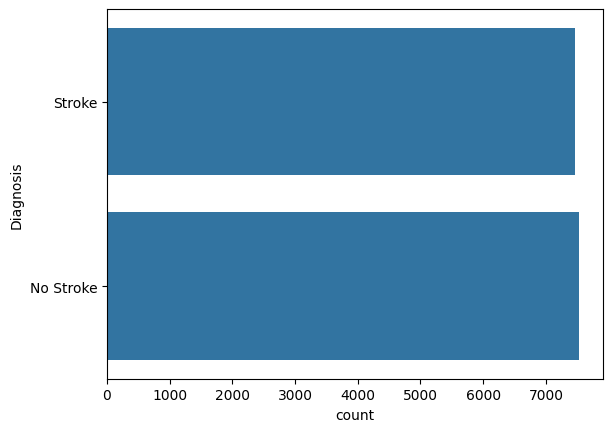

In [ ]:
print(data['Diagnosis'].value_counts())
sns.countplot(data['Diagnosis'])
plt.show()

### Gender Distribution by categories

Gender
Male      7622
Female    7378
Name: count, dtype: int64


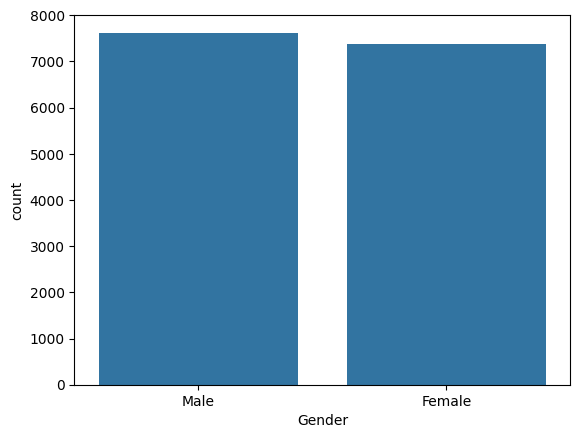

In [ ]:
print(data['Gender'].value_counts())
sns.barplot(data['Gender'].value_counts())
plt.show()

### Frequency Distribution for Age

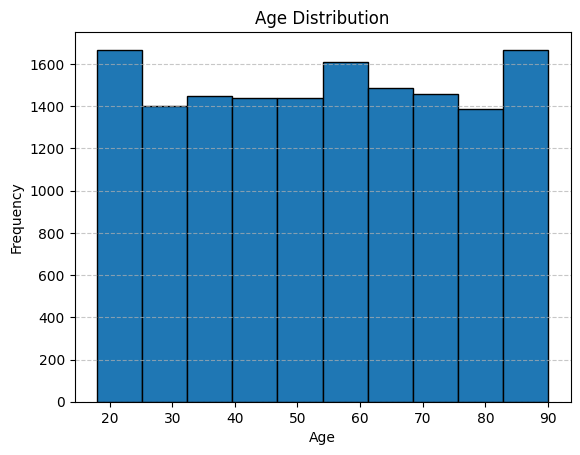

In [ ]:
plt.hist(data['Age'], edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###Analysis and data distribution in respect to Stroke

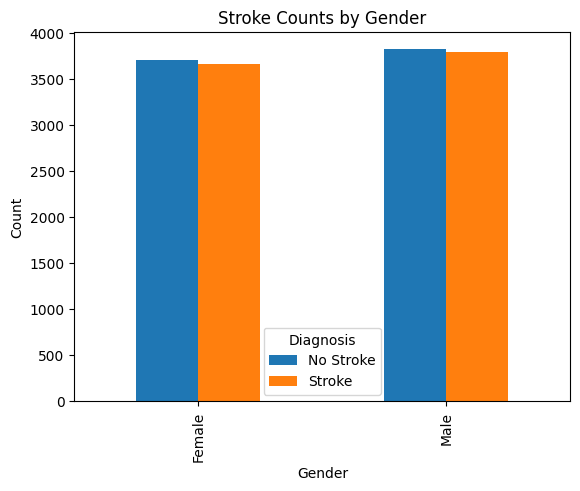

In [ ]:
gender_group = data.groupby(['Gender'])['Diagnosis'].value_counts().unstack()

gender_group.plot(kind='bar',stacked=False)
plt.title('Stroke Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
# plt.legend(title='Diagnosis', labels=['No Stroke', 'Stroke'])
plt.show()


Diagnosis  No Stroke  Stroke
Gender                      
Female          3709    3669
Male            3823    3799


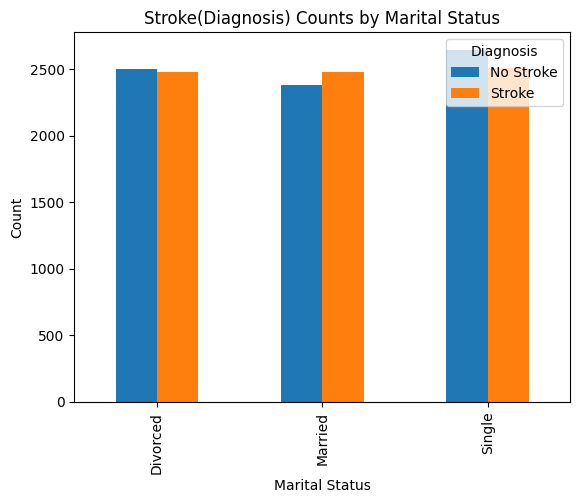

In [ ]:
married_group = data.groupby(['Marital Status'])['Diagnosis'].value_counts().unstack()
print(gender_group)
married_group.plot(kind='bar',stacked=False)
plt.title('Stroke(Diagnosis) Counts by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
# plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.show()

Diagnosis         No Stroke  Stroke
Alcohol Intake                     
Frequent Drinker       1872    1833
Never                  1899    1830
Rarely                 1878    1943
Social Drinker         1883    1862


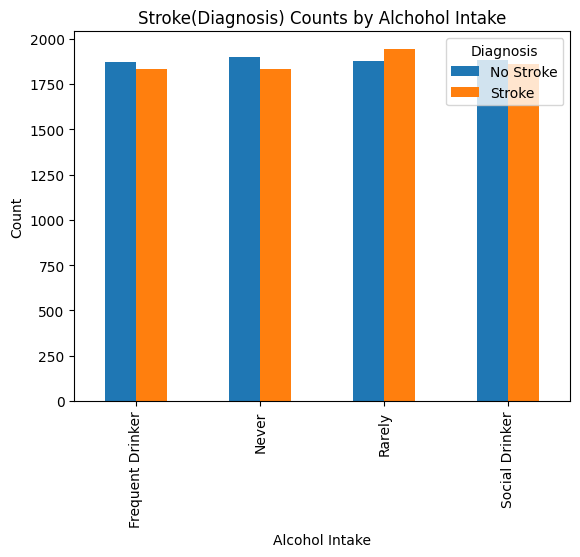

In [ ]:
smoking_group = data.groupby(['Alcohol Intake'])['Diagnosis'].value_counts().unstack()
print(smoking_group)
smoking_group.plot(kind='bar',stacked=False)
plt.title('Stroke(Diagnosis) Counts by Alchohol Intake')
plt.xlabel('Alcohol Intake')
plt.ylabel('Count')
# plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.show()

Diagnosis       No Stroke  Stroke
Work Type                        
Government Job       1858    1852
Never Worked         1807    1765
Private              1968    1895
Self-employed        1899    1956


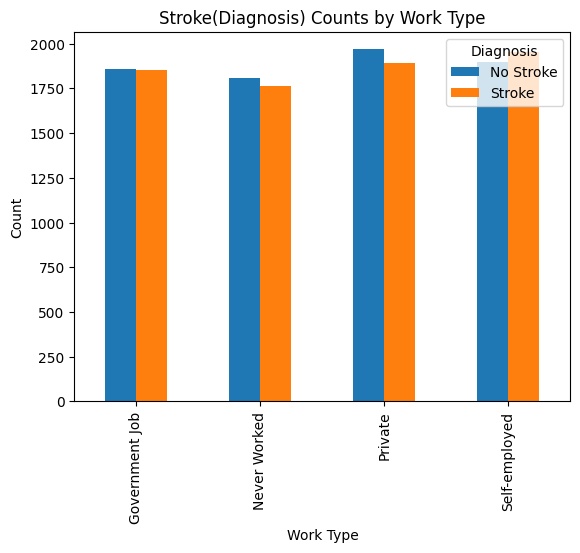

In [ ]:
smoking_group = data.groupby(['Work Type'])['Diagnosis'].value_counts().unstack()
print(smoking_group)
smoking_group.plot(kind='bar',stacked=False)
plt.title('Stroke(Diagnosis) Counts by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Count')
# plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.show()

###Analysis and data distribution in respect to hypertension

Hypertension         0    1
Alcohol Intake             
Frequent Drinker  2802  903
Never             2830  899
Rarely            2856  965
Social Drinker    2777  968


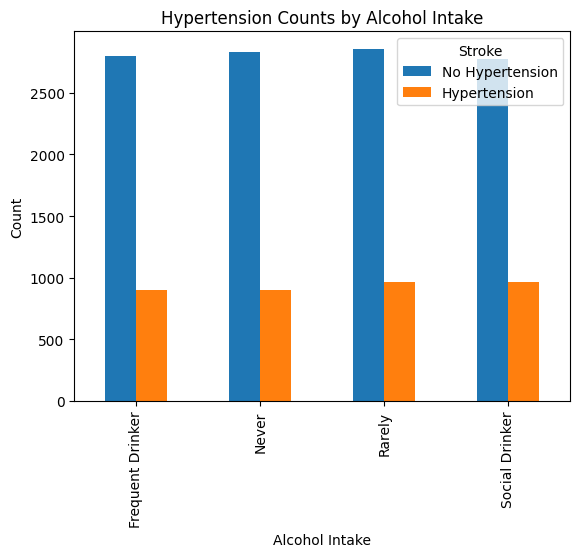

In [ ]:
smoking_group = data.groupby(['Alcohol Intake'])['Hypertension'].value_counts().unstack()
print(smoking_group)
smoking_group.plot(kind='bar',stacked=False)
plt.title('Hypertension Counts by Alcohol Intake')
plt.xlabel('Alcohol Intake')
plt.ylabel('Count')
plt.legend(title='Stroke', labels=['No Hypertension', 'Hypertension'])
plt.show()

Hypertension     0     1
Gender                  
Female        5562  1816
Male          5703  1919


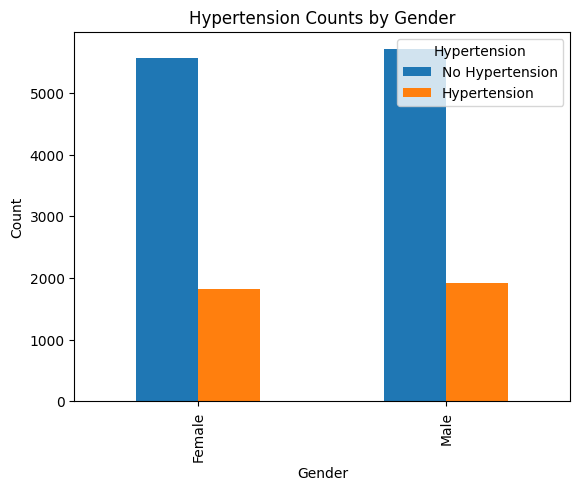

In [ ]:
gender_group = data.groupby(['Gender'])['Hypertension'].value_counts().unstack()
print(gender_group)
gender_group.plot(kind='bar',stacked=False)
plt.title('Hypertension Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hypertension', labels=['No Hypertension', 'Hypertension'])
plt.show()

###Analysis and data distribution in respect to heart disease

Heart Disease     0     1
Gender                   
Female         3687  3691
Male           3769  3853


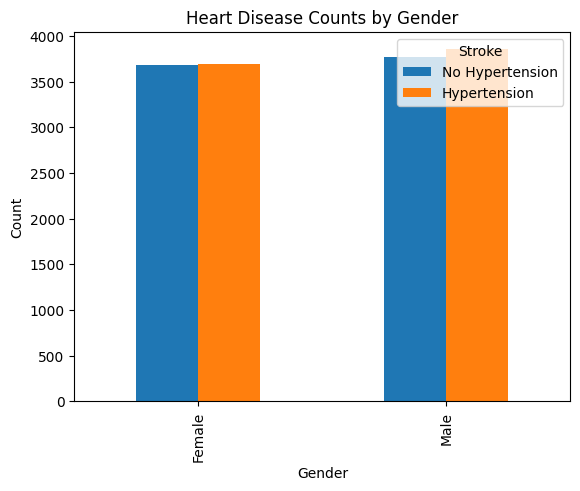

In [ ]:
gender_group = data.groupby(['Gender'])['Heart Disease'].value_counts().unstack()
print(gender_group)
gender_group.plot(kind='bar',stacked=False)
plt.title('Heart Disease Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Stroke', labels=['No Hypertension', 'Hypertension'])
plt.show()

###Hypertension Prevalence by Age

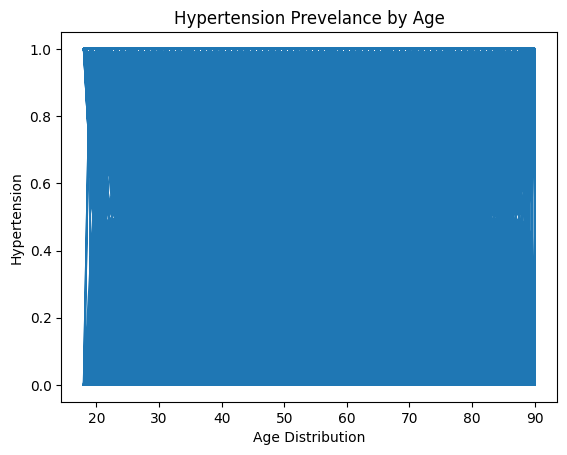

In [ ]:
plt.plot(data['Age'], data['Hypertension'], label=['Male', 'Female'])
plt.xlabel('Age Distribution')
plt.ylabel('Hypertension')
plt.title('Hypertension Prevelance by Age')
plt.show()

# Converting categorical values into numerical values by Encoding

In [ ]:
data.head(4)

,Age,Gender,Hypertension,Heart Disease,Marital Status,Work Type,Residence Type,Average Glucose Level,Body Mass Index (BMI),Smoking Status,...,Physical Activity,Stroke History,Family History of Stroke,Dietary Habits,Stress Levels,Diagnosis,Systolic,Diastolic,HDL,LDL
0,56,Male,0,1,Married,Self-employed,Rural,130.91,22.37,Non-smoker,...,Moderate,0,Yes,Vegan,3.48,Stroke,Hypertensive Crisis,Hypertension,68,133
1,80,Male,0,0,Single,Self-employed,Urban,183.73,32.57,Non-smoker,...,Low,0,No,Paleo,1.73,Stroke,Hypertensive Crisis,Hypertension,63,70
2,26,Male,1,1,Married,Never Worked,Rural,189.00,20.32,Formerly Smoked,...,High,0,Yes,Paleo,7.31,Stroke,Hypertensive Crisis,Hypertension,59,95
3,73,Male,0,0,Married,Never Worked,Urban,185.29,27.50,Non-smoker,...,Moderate,0,No,Paleo,5.35,No Stroke,Hypertensive Crisis,Hypertension,70,137


## Categorical Encoding

In [ ]:
diagnosis_mapping = {'No Stroke': 0, 'Stroke': 1}
data['Diagnosis'] = data['Diagnosis'].map(diagnosis_mapping)

In [ ]:
data_encoded = pd.get_dummies(data, columns=data.select_dtypes(include=['object']).columns)
data_encoded = data_encoded.astype('int64')
data_encoded

,Age,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Stress Levels,Diagnosis,HDL,LDL,...,Dietary Habits_Pescatarian,Dietary Habits_Vegan,Dietary Habits_Vegetarian,Systolic_Elevated,Systolic_Hypertension,Systolic_Hypertensive Crisis,Systolic_Normal,Diastolic_Elevated,Diastolic_Hypertension,Diastolic_Normal
0,56,0,1,130,22,0,3,1,68,133,...,0,1,0,0,0,1,0,0,1,0
1,80,0,0,183,32,0,1,1,63,70,...,0,0,0,0,0,1,0,0,1,0
2,26,1,1,189,20,0,7,1,59,95,...,0,0,0,0,0,1,0,0,1,0
3,73,0,0,185,27,0,5,0,70,137,...,0,0,0,0,0,1,0,0,1,0
4,51,1,1,177,29,0,6,1,65,68,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,88,1,1,160,39,0,1,0,44,153,...,0,0,0,0,0,1,0,0,1,0
14996,47,0,0,107,22,1,1,0,35,183,...,0,0,0,0,0,1,0,1,0,0
14997,35,0,0,134,26,1,0,1,57,159,...,0,0,0,1,0,0,0,0,1,0
14998,73,0,0,169,28,0,1,0,79,91,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
data_encoded.drop(['Family History of Stroke_No', 'Gender_Female' ], axis = 1, inplace = True)
data_encoded.rename(columns={'Gender_Male':'Gender', 'Family_History_of_Stroke_Yes':'Family_History_of_Stroke'}, inplace=True)
data_encoded.head()

,Age,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Stress Levels,Diagnosis,HDL,LDL,...,Dietary Habits_Pescatarian,Dietary Habits_Vegan,Dietary Habits_Vegetarian,Systolic_Elevated,Systolic_Hypertension,Systolic_Hypertensive Crisis,Systolic_Normal,Diastolic_Elevated,Diastolic_Hypertension,Diastolic_Normal
0,56,0,1,130,22,0,3,1,68,133,...,0,1,0,0,0,1,0,0,1,0
1,80,0,0,183,32,0,1,1,63,70,...,0,0,0,0,0,1,0,0,1,0
2,26,1,1,189,20,0,7,1,59,95,...,0,0,0,0,0,1,0,0,1,0
3,73,0,0,185,27,0,5,0,70,137,...,0,0,0,0,0,1,0,0,1,0
4,51,1,1,177,29,0,6,1,65,68,...,1,0,0,1,0,0,0,0,1,0


In [ ]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Age                              15000 non-null  int64
 1   Hypertension                     15000 non-null  int64
 2   Heart Disease                    15000 non-null  int64
 3   Average Glucose Level            15000 non-null  int64
 4   Body Mass Index (BMI)            15000 non-null  int64
 5   Stroke History                   15000 non-null  int64
 6   Stress Levels                    15000 non-null  int64
 7   Diagnosis                        15000 non-null  int64
 8   HDL                              15000 non-null  int64
 9   LDL                              15000 non-null  int64
 10  Gender                           15000 non-null  int64
 11  Marital Status_Divorced          15000 non-null  int64
 12  Marital Status_Married           15000 non-nul

## Normalize data

In [ ]:

# import pandas as pd
# from sklearn.preprocessing import normalize

# # Separate features and target
# target_col = 'Diagnosis'
# X = data_encoded.drop(columns=[target_col])
# y = data_encoded[target_col]


# #Normalize
# X_normalized = normalize(X)

# # Convert the scaled features back to a DataFrame for easier handling
# X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

# # Combine the scaled features with the target variable
# data_final = pd.concat([X_normalized_df, y], axis=1)


In [ ]:

from sklearn.preprocessing import MinMaxScaler

# Separate features and target
target_col = 'Diagnosis'
X = data_encoded.drop(columns=[target_col])
y = data_encoded[target_col]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Combine the scaled features with the target variable
data_final = pd.concat([X_scaled_df, y], axis=1)


In [ ]:
data_final.head()

,Age,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Stress Levels,HDL,LDL,Gender,...,Dietary Habits_Vegan,Dietary Habits_Vegetarian,Systolic_Elevated,Systolic_Hypertension,Systolic_Hypertensive Crisis,Systolic_Normal,Diastolic_Elevated,Diastolic_Hypertension,Diastolic_Normal,Diagnosis
0,0.527778,0.0,1.0,0.500000,0.28,0.0,0.3,0.76,0.561538,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,0.861111,0.0,0.0,0.878571,0.68,0.0,0.1,0.66,0.076923,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,0.111111,1.0,1.0,0.921429,0.20,0.0,0.7,0.58,0.269231,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
3,0.763889,0.0,0.0,0.892857,0.48,0.0,0.5,0.80,0.592308,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,0.458333,1.0,1.0,0.835714,0.56,0.0,0.6,0.70,0.061538,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1




# Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split,cross_val_score

X = data_final.drop(columns=[target_col])
y = data_final[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape,'\n')
print(X_test.shape,'\n')
print(y_train.shape,'\n')
print(y_test.shape,'\n')

(10500, 44) 

(4500, 44) 

(10500,) 

(4500,) 



In [ ]:
# prompt: balance dataset using smote

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)


## Metrics function

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluation_metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test,y_pred,)
    print("Evaluation Metrics:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:", conf)
    print("Classification Report:", cr)

In [ ]:
X_train.corr()

,Age,Hypertension,Heart Disease,Average Glucose Level,Body Mass Index (BMI),Stroke History,Stress Levels,HDL,LDL,Gender,...,Dietary Habits_Pescatarian,Dietary Habits_Vegan,Dietary Habits_Vegetarian,Systolic_Elevated,Systolic_Hypertension,Systolic_Hypertensive Crisis,Systolic_Normal,Diastolic_Elevated,Diastolic_Hypertension,Diastolic_Normal
Age,1.000000,0.015788,-0.014932,-0.004336,-0.011703,0.010940,0.008084,-0.001883,-0.005537,0.004439,...,-0.013164,0.011546,0.014189,0.004687,-0.004971,-0.003450,0.003898,-0.002261,0.002896,-0.002345
Hypertension,0.015788,1.000000,-0.010853,-0.001734,0.001890,0.002517,0.004212,-0.004567,-0.000969,-0.000185,...,-0.001225,0.007197,0.013033,0.004173,-0.002758,-0.003278,0.002617,-0.005741,0.005355,0.001237
Heart Disease,-0.014932,-0.010853,1.000000,0.015755,-0.006735,-0.018925,-0.002272,-0.013698,-0.001084,0.001529,...,-0.004881,0.005164,0.002413,0.007737,0.006159,0.006054,-0.015060,0.007964,-0.008273,0.001322
Average Glucose Level,-0.004336,-0.001734,0.015755,1.000000,-0.001990,-0.009546,0.004954,0.015748,0.006995,0.000150,...,0.024495,-0.015193,0.017353,0.003720,0.013060,-0.007818,-0.002503,-0.009774,0.012170,-0.008871
Body Mass Index (BMI),-0.011703,0.001890,-0.006735,-0.001990,1.000000,-0.000748,-0.000395,0.009388,0.021701,0.001357,...,-0.023146,-0.002553,0.010664,-0.002532,0.000100,0.001869,-0.000454,-0.010123,0.007236,0.010112
Stroke History,0.010940,0.002517,-0.018925,-0.009546,-0.000748,1.000000,0.002897,-0.021049,0.002918,0.007498,...,0.000763,-0.016688,0.004877,-0.007356,0.017383,-0.015300,0.009390,0.014891,-0.012562,-0.007978
Stress Levels,0.008084,0.004212,-0.002272,0.004954,-0.000395,0.002897,1.000000,0.008617,0.009501,-0.016388,...,0.013520,0.015679,0.003475,-0.000311,-0.009159,0.001906,0.004075,-0.002790,0.003607,-0.003013
HDL,-0.001883,-0.004567,-0.013698,0.015748,0.009388,-0.021049,0.008617,1.000000,0.002537,0.026380,...,0.002732,-0.012431,0.005835,0.005710,-0.009855,0.012095,-0.009850,0.004962,-0.004785,-0.000502
LDL,-0.005537,-0.000969,-0.001084,0.006995,0.021701,0.002918,0.009501,0.002537,1.000000,0.015303,...,-0.003282,-0.006287,0.006861,-0.004121,-0.005452,-0.005142,0.011419,-0.012105,0.013665,-0.005930
Gender,0.004439,-0.000185,0.001529,0.000150,0.001357,0.007498,-0.016388,0.026380,0.015303,1.000000,...,-0.015331,-0.004090,0.004939,-0.010104,0.003138,0.004256,-0.000218,-0.011020,0.009565,0.004939


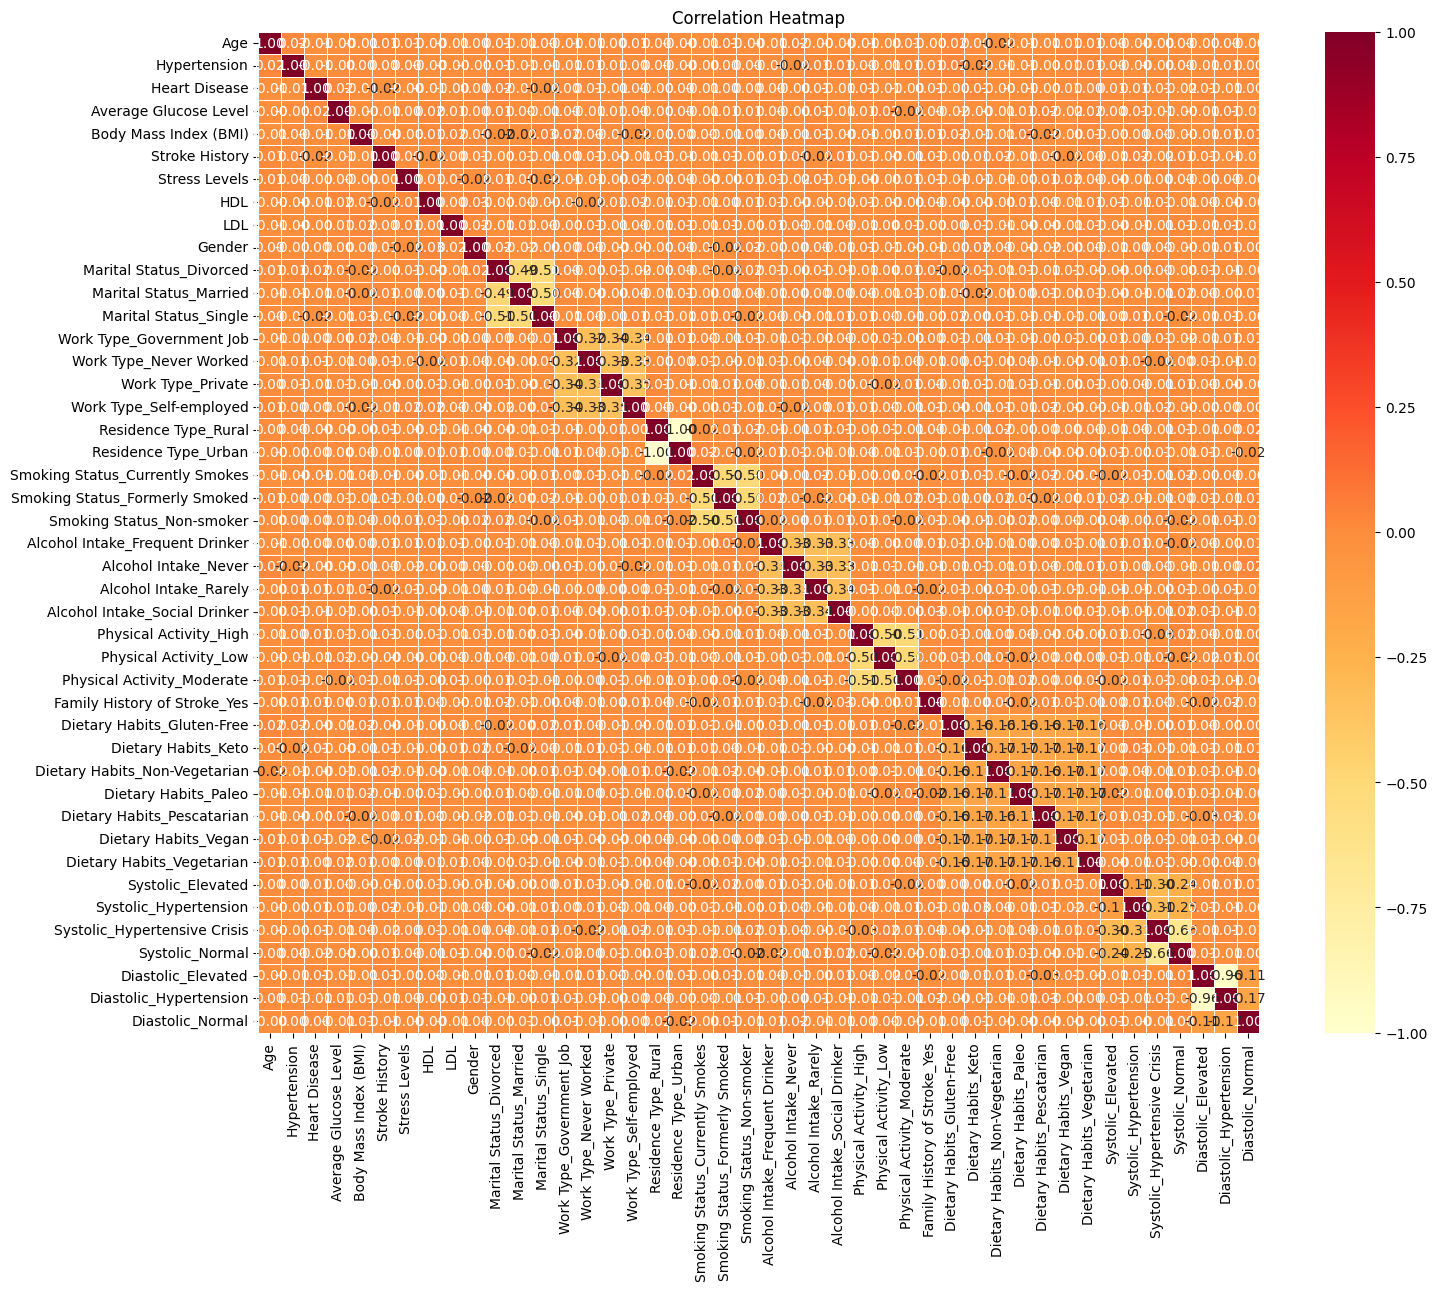

In [ ]:
plt.figure(figsize=(17, 13))
sns.heatmap(X_train.corr(), annot=True, cmap='YlOrRd', fmt=".2f", cbar=True, square=True, linewidths=.5, vmin=-1, vmax=1)

plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set to store correlated column names
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # absolute correlation value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.5)
len(set(corr_features))

7

In [ ]:
corr_features

{'Diastolic_Hypertension',
 'Marital Status_Single',
 'Physical Activity_Low',
 'Physical Activity_Moderate',
 'Residence Type_Urban',
 'Smoking Status_Non-smoker',
 'Systolic_Normal'}

In [ ]:
# X_train.drop(corr_features, axis = 1)
# X_test.drop(corr_features, axis = 1)

## Radial Basic Function (RBF)

In [ ]:
from drive.MyDrive.stroke.kmeans import kmeans

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.8508666666666667

In [ ]:
y_pred = gpc.predict(X_test)
evaluation_metrics(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.5028888888888889
Confusion Matrix: [[2263    0]
 [2237    0]]
Classification Report:               precision    recall  f1-score   support

           0       0.50      1.00      0.67      2263
           1       0.00      0.00      0.00      2237

    accuracy                           0.50      4500
   macro avg       0.25      0.50      0.33      4500
weighted avg       0.25      0.50      0.34      4500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# kfold = KFold(n_splits=2)
# histories =[]


# rbfLayer = rbflayer.RBFLayer(16,
#                                initializer = kmeans_initializer.InitCentersKMeans(X_train),
#                                betas=2.0,
#                               input_shape=[X_train.shape[1]])
# model =keras.models.Sequential()
# model.add(rbfLayer)
# model.add(layers.Dense(1))
# model.compile(loss='mae',
#               optimizer=RMSprop(),
#               metrics=['accuracy'])
# print(model.summary())

In [ ]:
model = Sequential()
rbflayer = RBFLayer(34,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=[X_train.shape[1]])
model.add(rbflayer)
model.add(Dense(4))
# model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(), metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_1 (RBFLayer)      (None, 34)                1530      
                                                                 
 dense_1 (Dense)             (None, 4)                 140       
                                                                 
Total params: 1670 (6.52 KB)
Trainable params: 1670 (6.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history1 = model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
330/330 [==============================] - 2s 4ms/step - loss: 0.3689 - accuracy: 0.3504
Epoch 2/1000
330/330 [==============================] - 1s 4ms/step - loss: 0.2578 - accuracy: 0.3603
Epoch 3/1000
330/330 [==============================] - 3s 8ms/step - loss: 0.2500 - accuracy: 0.3704
Epoch 4/1000
330/330 [==============================] - 2s 5ms/step - loss: 0.2501 - accuracy: 0.4156
Epoch 5/1000
330/330 [==============================] - 1s 4ms/step - loss: 0.2501 - accuracy: 0.3895
Epoch 6/1000
330/330 [==============================] - 1s 3ms/step - loss: 0.2501 - accuracy: 0.4032
Epoch 7/1000
330/330 [==============================] - 1s 2ms/step - loss: 0.2501 - accuracy: 0.4322
Epoch 8/1000
330/330 [==============================] - 1s 2ms/step - loss: 0.2501 - accuracy: 0.4288
Epoch 9/1000
330/330 [==============================] - 1s 2ms/step - loss: 0.2501 - accuracy: 0.4021
Epoch 10/1000
330/330 [==============================] - 1s 2ms/step - loss: 0.250

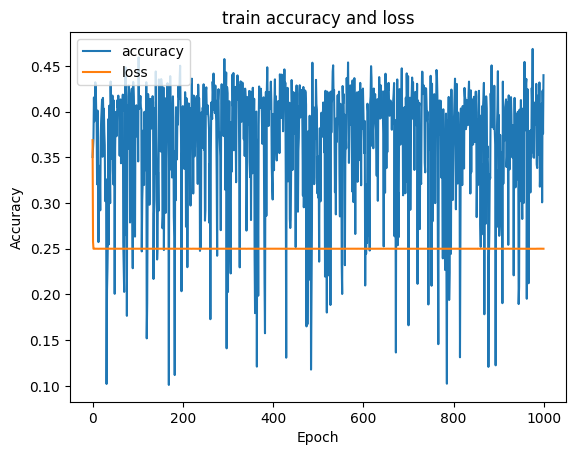

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])
plt.title('train accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [ ]:
# Train the model with early stopping and model checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# callbacks=[early_stopping]
history = model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test), validation_split=0.2, verbose=1)

histories.append(history)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('train accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()
# histories.append(history)

In [ ]:
 pd.DataFrame(histories[0].history).plot()

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# RECURSIVE FEATURE ELIMINATION

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

X = data_final.drop(columns=[target_col])
y = data_final[target_col]


# Feature selection using Recursive Feature Elimination (RFE) with Random Forest
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=25)
fit = rfe.fit(X, y)

print("Selected features based on RFE:")
selected_features_rfe = X.columns[fit.support_]
print(selected_features_rfe)

# Update the DataFrame with selected features
final_selected_features = selected_features_rfe
data_final_selected = pd.concat([data_final[final_selected_features], y], axis=1)

print("Final selected DataFrame:")
data_final_selected.head()


In [ ]:
# Visualize the feature importances
plt.figure(figsize=(10, 6))
feature_importances = fit.estimator_.feature_importances_
sns.barplot(x=feature_importances, y=final_selected_features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.show()

In [ ]:
  xx = data_final_selected.drop(columns=[target_col])
  yy = data_final_selected[target_col]
  X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3, random_state=0)

In [ ]:
print('X_train: ',X_train.shape,'\n')
print('X_test: ',X_test.shape,'\n')
print('y_train: ',y_train.shape,'\n')
print('y_test: ',y_test.shape, '\n')

## Radial Basic Function

In [ ]:
kfold = KFold(n_splits=2)
histories =[]



rbfLayer = rbflayer.RBFLayer(16,
                               initializer = kmeans_initializer.InitCentersKMeans(X_train),
                               betas=2.0,
                              input_shape=[X_train.shape[1]])
model =keras.models.Sequential()
model.add(rbfLayer)
model.add(layers.Dense(1))
model.compile(loss='mae',
              optimizer=RMSprop(),
              metrics=['accuracy'])
print(model.summary())

In [ ]:
# Train the model with early stopping and model checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# callbacks=[early_stopping]
history = model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_test, y_test), validation_split=0.2, verbose=1)

histories.append(history)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('train accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()
# histories.append(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict the labels for the test data
y_pred = model.predict(X_test)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = [int(round(p[0])) for p in y_pred]

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)